In [13]:
import cv2
import numpy
import math
import os
from keras.preprocessing.image import img_to_array, load_img
from PIL import Image
import keras

In [18]:
classes = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    '7': 7,
    '8': 8,
    '9': 9,
    'a': 10,
    'b': 11,
    'c': 12,
    'd': 13,
    'e': 14,
    'f': 15,
    'g': 16,
    'h': 17,
    'i': 18,
    'j': 19,
    'k': 20,
    'l': 21,
    'm': 22,
    'n': 23,
    'o': 24,
    'p': 25,
    'q': 26,
    'r': 27,
    's': 28,
    't': 29,
    'u': 30,
    'v': 31,
    'w': 32,
    'x': 33,
    'y': 34,
    'z': 35,
}

In [10]:
model = keras.models.load_model('E:/set_model.model')

In [19]:
def identifyGesture(handTrainImage):
    
    handTrainImage = cv2.cvtColor(handTrainImage, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(handTrainImage)
    img_w, img_h = img.size
    M = max(img_w, img_h)
    background = Image.new('RGB', (M, M), (0, 0, 0))
    bg_w, bg_h = background.size
    offset = ((bg_w - img_w) // 2, (bg_h - img_h) // 2)
    background.paste(img, offset)
    size = 64,64
    background = background.resize(size, Image.ANTIALIAS)

    open_cv_image = numpy.array(background)
    background = open_cv_image.astype('float32')
    background = background / 255
    background = background.reshape((1,) + background.shape)
    predictions = model.predict_classes(background)

    # print predicted class and get the class name (character name) for the given class number and return it
    print(predictions)
    for key, value in classes.items(): 
         if predictions[0] == value: 
            c=key 
    
    return c

In [20]:
def nothing(x):
    pass

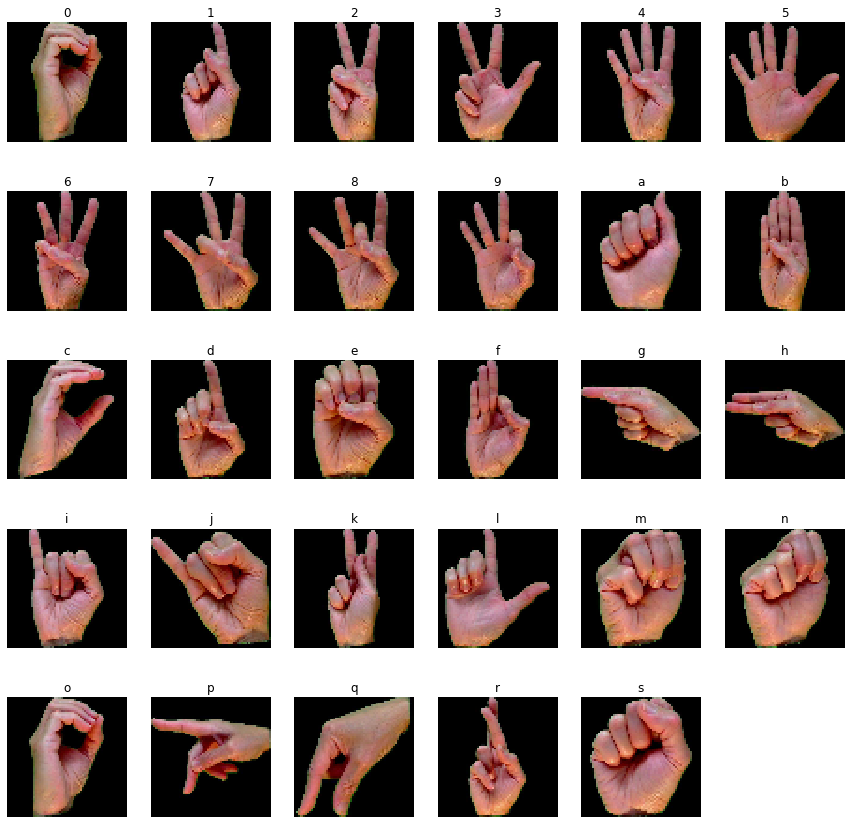

In [21]:
import matplotlib.pyplot as plt
def load_unique():
    size_img = 64,64 
    images_for_plot = []
    labels_for_plot = []
    path='E:/asl_dataset'
    for folder in os.listdir(path):
        for file in os.listdir(path + '/' + folder):
            filepath = path + '/' + folder + '/' + file
            image = cv2.imread(filepath)
            final_img = cv2.resize(image, size_img)
            final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
            images_for_plot.append(final_img)
            labels_for_plot.append(folder)
            break
    return images_for_plot, labels_for_plot

images_for_plot, labels_for_plot = load_unique()
fig = plt.figure(figsize = (15,15))
def plot_images(fig, image, label, row, col, index):
    fig.add_subplot(row, col, index)
    plt.axis('off')
    plt.imshow(image)
    plt.title(label)
    return

image_index = 0
row = 5
col = 6
for i in range(1,(row*col)):
    plot_images(fig, images_for_plot[image_index], labels_for_plot[image_index], row, col, i)
    image_index = image_index + 1
plt.show()

In [ ]:
cv2.namedWindow('Camera Output')
cv2.namedWindow('Hand')
cv2.namedWindow('HandTrain')

cv2.createTrackbar('B for min', 'Camera Output', 0, 255, nothing)
cv2.createTrackbar('G for min', 'Camera Output', 0, 255, nothing)
cv2.createTrackbar('R for min', 'Camera Output', 0, 255, nothing)
cv2.createTrackbar('B for max', 'Camera Output', 0, 255, nothing)
cv2.createTrackbar('G for max', 'Camera Output', 0, 255, nothing)
cv2.createTrackbar('R for max', 'Camera Output', 0, 255, nothing)


cv2.setTrackbarPos('B for min', 'Camera Output', 0)
cv2.setTrackbarPos('G for min', 'Camera Output', 130)
cv2.setTrackbarPos('R for min', 'Camera Output', 103)
cv2.setTrackbarPos('B for max', 'Camera Output', 255)
cv2.setTrackbarPos('G for max', 'Camera Output', 182)
cv2.setTrackbarPos('R for max', 'Camera Output', 130)

videoFrame = cv2.VideoCapture(0)
keyPressed = -1
palm_cascade = cv2.CascadeClassifier('E:/palm.xml')
x_crop_prev, y_crop_prev, w_crop_prev, h_crop_prev = 0, 0, 0, 0
_, prevHandImage = videoFrame.read()
prevcnt = numpy.array([], dtype=numpy.int32)
gestureStatic = 0
gestureDetected = 0

letterDetected=''

while keyPressed < 0:  

    # Getting min and max colors for skin
    min_YCrCb = numpy.array([cv2.getTrackbarPos('B for min', 'Camera Output'),
                             cv2.getTrackbarPos('G for min', 'Camera Output'),
                             cv2.getTrackbarPos('R for min', 'Camera Output')], numpy.uint8)
    max_YCrCb = numpy.array([cv2.getTrackbarPos('B for max', 'Camera Output'),
                             cv2.getTrackbarPos('G for max', 'Camera Output'),
                             cv2.getTrackbarPos('R for max', 'Camera Output')], numpy.uint8)
    
    
    readSucsess, sourceImage = videoFrame.read()

    # Convert image to YCrCb
    imageYCrCb = cv2.cvtColor(sourceImage, cv2.COLOR_BGR2YCR_CB)
    imageYCrCb = cv2.GaussianBlur(imageYCrCb, (5, 5), 0)

    # Find region with skin tone in YCrCb image
    skinRegion = cv2.inRange(imageYCrCb, min_YCrCb, max_YCrCb)

    # Do contour detection on skin region
    _, contours, hierarchy = cv2.findContours(skinRegion, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # sorting contours by area. Largest area first.
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # get largest contour and compare with largest contour from previous frame.
    # set previous contour to this one after comparison.
    cnt = contours[0]
    ret = cv2.matchShapes(cnt, prevcnt, 2, 0.0)
    prevcnt = contours[0]

    # once we get contour, extract it without background into a new window called handTrainImage
    stencil = numpy.zeros(sourceImage.shape).astype(sourceImage.dtype)
    color = [255, 255, 255]
    cv2.fillPoly(stencil, [cnt], color)
    handTrainImage = cv2.bitwise_and(sourceImage, stencil)

    # if comparison returns a high value (shapes are different), start gestureStatic over. Else increment it.
    if (ret > 0.70):
        gestureStatic = 0
    else:
        gestureStatic += 1

    # crop coordinates for hand.
    x_crop, y_crop, w_crop, h_crop = cv2.boundingRect(cnt)

    # place a rectange around the hand.
    cv2.rectangle(sourceImage, (x_crop, y_crop), (x_crop + w_crop, y_crop + h_crop), (0, 255, 0), 2)

    # if the crop area has changed drastically form previous frame, update it.
    if (abs(x_crop - x_crop_prev) > 50 or abs(y_crop - y_crop_prev) > 50 or
                abs(w_crop - w_crop_prev) > 50 or abs(h_crop - h_crop_prev) > 50):
        x_crop_prev = x_crop
        y_crop_prev = y_crop
        h_crop_prev = h_crop
        w_crop_prev = w_crop

    # create crop image
    handImage = sourceImage.copy()[max(0, y_crop_prev - 50):y_crop_prev + h_crop_prev + 50,
                max(0, x_crop_prev - 50):x_crop_prev + w_crop_prev + 50]

    # Training image with black background
    handTrainImage = handTrainImage[max(0, y_crop_prev - 15):y_crop_prev + h_crop_prev + 15,
                     max(0, x_crop_prev - 15):x_crop_prev + w_crop_prev + 15]

    # if gesture is static for 10 frames, set gestureDetected to 10 and display "gesture detected"
    # on screen for 10 frames.
    
    if gestureStatic == 10:
        gestureDetected = 10
        print("Gesture Detected")
        letterDetected1  = identifyGesture(handTrainImage)  # todo: Ashish fill this function to return actual character
        letterDetected = letterDetected + letterDetected1
        print(letterDetected)
        
    if gestureDetected > 0:
        if (letterDetected != None):
            cv2.putText(sourceImage, letterDetected, (10, 400), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 2)
        gestureDetected -= 1

    

    # Display the source image and cropped image
    cv2.imshow('Camera Output', handImage)
    cv2.imshow('Hand', handTrainImage )
    cv2.imshow('HandTrain', sourceImage)

    # Check for user input to close program
    keyPressed = cv2.waitKey(30)  # wait 30 miliseconds in each iteration of while loop

# Close window and camera after exiting the while loop
cv2.destroyWindow('Camera Output')
cv2.destroyAllWindows()
videoFrame.release()

In [ ]:
cv2.destroyAllWindows()